In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from shapely import Polygon
from bbtoolkit.structures.geometry import TexturedPolygon
from bbtoolkit.math.geometry import create_cartesian_space, regroup_min_max
from bbtoolkit.data.configparser import EvalConfigParser
import configparser
from typing import Any, Callable, Literal
from bbtoolkit.structures.synapses import DirectedTensorGroup, DirectedTensor, dict2directed_tensor
from bbtoolkit.math import pol2cart
from bbtoolkit.preprocessing.neural_generators import GCMap
from bbtoolkit.preprocessing.environment import Environment, Object, SpatialParameters
from bbtoolkit.preprocessing.neural_generators import MTLGenerator, TCGenerator


from collections import OrderedDict
from functools import partial
from bbtoolkit.data import Cached
from bbtoolkit.preprocessing.environment.compilers import EnvironmentCompiler, DynamicEnvironmentCompiler
from bbtoolkit.preprocessing.environment.builders import EnvironmentBuilder
from bbtoolkit.preprocessing.environment.utils import env2builder


In [2]:
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

['../cfg/connectivity/main.ini']

In [3]:
def connectivity_config2dict(
    config: EvalConfigParser,
    populations: tuple[str, ...] = None,
    ignore: tuple[str, ...] = None
) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.
        populations (tuple[str, ..], optional): A tuple of sections to include.
            If None, read all sections except of 'ExternalSources' and 'Hyperparameters'. Defaults to None.
        ignore (tuple[str, ..], optional): A tuple of sections to ignore. 'ExternalSources' and 'Hyperparameters' sections are always ignored. Defaults to None.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    if populations is None:
        populations = tuple(config.sections())

    if ignore is None:
        ignore = {'ExternalSources', 'Hyperparameters'}
    else:
        ignore = set(list(ignore) + ['ExternalSources', 'Hyperparameters'])

    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section in populations and section not in ignore
    }
    return out


In [4]:
configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

In [5]:
simconfig_path = '../cfg/simulation/one_one.ini'
simconfig = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
simconfig.read(simconfig_path)

dt = simconfig.eval('Simulation', 'dt')
step = simconfig.eval('Simulation', 'step')
lesion_noise_level =  simconfig.eval('Simulation', 'lesion_noise_level')
fr_noise_level = simconfig.eval('Simulation', 'fr_noise_level')

In [305]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

environment = Environment.load('../data/envs/main_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    h_sig,
    sigma_angular,
    n_steps
)

mtl_gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, environment
)

In [320]:
def compute_euclidean_distance(x, y, x0, y0):
    return np.sqrt((x - x0)**2 + (y - y0)**2)

compute_euclidean_distance(
    x=2j, y=2j, x0=-1j, y0=-1j
)

4.242640687119285j

In [306]:
from bbtoolkit.math.geometry import calculate_polar_distance


polar_distance = calculate_polar_distance(tc_gen.r_max)
# polar_angle = np.arange(0, tc_gen.n_bvc_theta * tc_gen.polar_ang_res, tc_gen.polar_ang_res)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle

In [307]:
h_coords, *_ = mtl_gen.get_coords()
# pdist, pang = tc_gen.polar_distance, tc_gen.polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)

In [9]:
trajectory_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
trajectory_cfg.read('../cfg/trajectory/papez_circuit_lesion.ini')

agent_cfg = trajectory_cfg['AgentPosition']
agent_x = agent_cfg.eval('x')
agent_y = agent_cfg.eval('y')
agent_hd = agent_cfg.eval('theta', locals={'pi': np.pi})
agent_v = agent_cfg.eval('v')

mode_cfg = trajectory_cfg['Mode']
perception = mode_cfg.eval('perception')
imagery = mode_cfg.eval('imagery')
movement = mode_cfg.eval('movement')
imaginary_movement = mode_cfg.eval('imaginary_movement')
stand_time = mode_cfg.eval('stand_t')

targets_cfg = trajectory_cfg['Targets']
locate_next_target = targets_cfg.eval('locate_next_target')
move_to_next_target = targets_cfg.eval('move_to_next_target')
rotation_resolved = targets_cfg.eval('rotation_resolved')
targets = np.array(targets_cfg.eval('targets'))

itargets_cfg = trajectory_cfg['ImaginaryTargets']
ilocate_next_target = itargets_cfg.eval('locate_next_target')
imove_to_next_target = itargets_cfg.eval('move_to_next_target')
irotation_resolved = itargets_cfg.eval('rotation_resolved')
itargets = np.array(itargets_cfg.eval('targets'))
idwell_time = itargets_cfg.eval('dwell')

objects_cfg = trajectory_cfg['Objects']
object_coords = np.array(objects_cfg.eval('coords'))
encoding_threshold = objects_cfg.eval('encoding_threshold')


connectivity_modified = connectivity.operation_with(
    DirectedTensorGroup(
        *dict2directed_tensor(
            connectivity_config2dict(
                trajectory_cfg, ignore=('AgentPosition', 'Mode', 'Targets', 'ImaginaryTargets', 'Objects')
            )
        )
    ),
    lambda dict1, dict2:
        {
            key: dict1.get(key, 1) * dict2.get(key, 1)
            for key in set(dict1) | set(dict2)
        }
)

In [10]:
connectivity_modified.connection_map

,pr,rot,hd,pw,tr,gc,ic,otr,ip,h,ovc,opw,opr,bvc,pc
pr,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
rot,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
hd,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
pw,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
tr,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0
gc,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
ic,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
otr,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
ip,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0
h,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0


In [11]:
connectivity.gc.to.gc

{'inhibitory_phi': 0.2, 'tau': 0.02, 'beta': 0.1, 'alpha': 5}

### BVC Activity

In [2]:
from bbtoolkit.preprocessing.environment.fov import FOVManager
from bbtoolkit.preprocessing.environment.fov.ego import EgoManager
from bbtoolkit.preprocessing.environment.viz import plot_arrow, plot_polygon
from bbtoolkit.preprocessing.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.preprocessing.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.structures.geometry import Texture


In [8]:


builder = EnvironmentBuilder.load('./env.ini')
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=TransparentObjects()
)

compiler.add_wall(
    TexturedPolygon(
        Polygon([
            (-3, -5),
            (0, -5),
            (0, -6),
            (-3, -6)
        ]),
        texture=Texture(
            id_=10,
            color='#000000',
            name='black'
        )
    ),
    TexturedPolygon(
        Polygon([
            (3, -5),
            (2, -5),
            (2, -6),
            (3, -6)
        ]),
        texture=Texture(
            id_=10,
            color='#000000',
            name='black'
        )
    )
)


fov_angle = np.pi*.9
position = 1, -5
direction = -np.pi/2
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

env = compiler.environment
walls_fov, objects_fov = fov_manager(position, direction)
fig, ax = plt.subplots()
fig = plot_arrow(direction, *position, ax=ax)

for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

for wall, poly in zip(walls_fov, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

for obj, poly in zip(objects_fov, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)


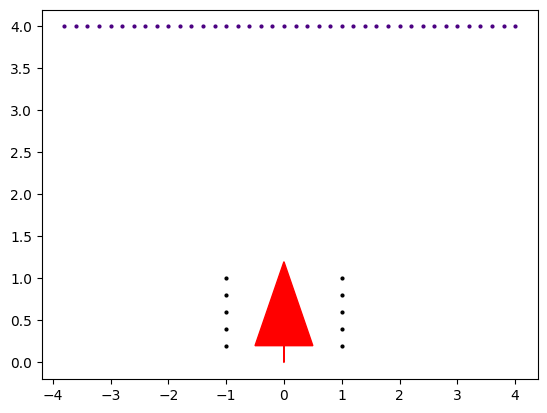

In [13]:
env = compiler.environment

ego_manager = EgoManager(fov_manager)

walls_ego, objects_ego = ego_manager(position, direction)

fig, ax = plt.subplots()
fig = plot_arrow(np.pi/2, *(0, 0), ax=ax)

for wall, poly in zip(walls_ego, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

for obj, poly in zip(objects_ego, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

In [288]:
import scipy as sp

def get_farthest_point_index(points):
    centroid = np.mean(points, axis=0)
    distances_from_centroid = np.linalg.norm(points - centroid, axis=1)
    return np.argmax(distances_from_centroid)

def sort_points_by_proximity(points):
    # Find the most distant point from the centroid
    farthest_index = get_farthest_point_index(points)
    starting_point = points[farthest_index]

    # Initialize the sorted points array
    sorted_points = np.zeros_like(points)
    sorted_points[0] = starting_point
    remaining_points = np.delete(points, farthest_index, axis=0).tolist()

    # Sort the remaining points by proximity
    for i in range(1, len(points)):
        current_point = sorted_points[i-1]
        distances = np.linalg.norm(np.array(remaining_points) - current_point, axis=1)
        closest_index = np.argmin(distances)
        sorted_points[i] = remaining_points.pop(closest_index)

    return sorted_points


def mask_to_slices(mask):
    ranges = np.concatenate([[0], np.where(~mask)[0] + 1, [len(mask)]])
    return [slice(start, end) for start, end in zip(ranges[:-1], ranges[1:])]


def split_points(points):
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
    res = sp.stats.mode(distances)
    return [points[slice_, :] for slice_ in mask_to_slices(np.isclose(distances, res.mode))]


def points2segments(coords):
    # Ensure coords is a sequence
    coords = sort_points_by_proximity(coords)
    # Split interrupted segments
    connected_segments = split_points(coords)

    all_segments = []
    for points in connected_segments:

        # Split the coordinates into x and y components
        x_coords, y_coords = points[:, 0], points[:, 1]

        # Create segments by "zipping" adjacent points
        all_segments.append(np.column_stack((x_coords[:-1], y_coords[:-1], x_coords[1:], y_coords[1:])))

    return np.concatenate(all_segments)


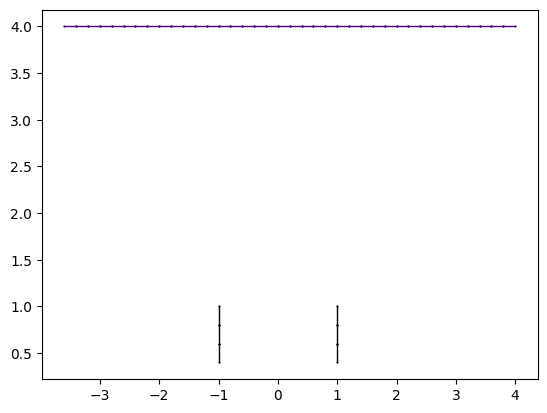

In [15]:

all_segments = list()
for wall_fov, poly in zip(walls_ego, compiler.environment.walls):
    if not wall_fov.size:
        continue
    wall_segments = points2segments(wall_fov)
    all_segments.append(wall_segments)
    for seg in wall_segments:
        x_start, y_start, x_end, y_end = seg
        plt.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1, marker='.', markersize=1)

all_segments = np.concatenate(all_segments)

In [16]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Any, Callable, Generator

from numpy import ndarray
from bbtoolkit.data import Copyable
from bbtoolkit.structures.synapses import BaseTensor, AbstractTensorGroup


class NamedTensor(BaseTensor):
    """
    A data class representing a named tensor.

    Attributes:
        name (str): The name of the tensor.
        weights (np.ndarray): The numerical data of the tensor, stored in a numpy array.
    """
    def __init__(self, name: str, weights: np.ndarray):
        super().__init__(weights)
        self.name = name


class TensorGroup(AbstractTensorGroup):
    """
    A class that groups multiple NamedTensors and provides methods to add or remove tensors from the group.

    Attributes:
        data (Dict[str, np.ndarray]): A dictionary mapping tensor names to their corresponding numpy arrays.
    """
    def __init__(self, *tensors: NamedTensor):
        """
        Initializes a TensorGroup with a sequence of NamedTensors.

        Args:
            *tensors (NamedTensor): An unpacked sequence of NamedTensor objects to be included in the group.
        """
        self.data = dict()
        for tensor in tensors:
            self.add_tensor(tensor)

    def add_tensor(self, tensor: NamedTensor):
        """
        Adds a NamedTensor to the TensorGroup.

        Args:
            tensor (NamedTensor): The NamedTensor to be added to the group.
        """
        self.data[tensor.name] = tensor.weights
        self.__setattr__(tensor.name, self.data[tensor.name])

    def remove_tensor(self, name: str):
        """
        Removes a NamedTensor from the TensorGroup by its name.

        Args:
            name (str): The name of the tensor to be removed.

        Raises:
            KeyError: If the tensor with the given name does not exist in the group.
        """
        del self.data[name]
        del self.__dict__[name]

    def __getitem__(self, key: str) -> np.ndarray:
        """
        Returns the numpy array corresponding to the given tensor name.

        Args:
            key (str): The name of the tensor.

        Returns:
            np.ndarray: The numerical data of the tensor.
        """
        return self.data[key]

    def __iter__(self) -> Generator[NamedTensor, None, None]:
        """
        A generator that yields NamedTensor objects from the TensorGroup.

        Yields:
            NamedTensor: The next NamedTensor in the group.
        """
        for tensor in self.data:
            yield NamedTensor(tensor, self.data[tensor])

    def operation_with(
        self,
        other: 'TensorGroup',
        operation: Callable[[ndarray, ndarray], ndarray],
        on_missing_weights: Literal['raise', 'ignore', 'concat'] | Callable[[np.ndarray], np.ndarray] = 'raise',
    ) -> 'TensorGroup':
        """
        Applies a binary operation to the tensors of two TensorGroups.

        Args:
            other (TensorGroup): The other TensorGroup to be used in the operation.
            operation (Callable[[np.ndarray, np.ndarray], np.ndarray]): A function that takes two numpy arrays and returns a third.
            on_missing_weights (Literal['raise', 'ignore', 'concat'] | Callable[[np.ndarray], np.ndarray], optional): A strategy to handle missing weights.
                If 'raise', a KeyError is raised. If 'ignore', the missing weights are skipped. If 'concat', the missing weights are concatenated. Defaults to 'raise'.

        Returns:
            TensorGroup: A new TensorGroup with the results of the operation.
        """
        new_data = deepcopy(self.data)
        for tensor, weights in other.data.items():
            if tensor in new_data:
                new_data[tensor] = operation(new_data[tensor], weights)
            else:
                if on_missing_weights == 'raise':
                    raise KeyError(f"Tensor '{tensor}' is not present in the group.")
                elif on_missing_weights == 'ignore':
                    continue
                elif on_missing_weights == 'concat':
                    new_data[tensor] = weights
                elif isinstance(on_missing_weights, Callable):
                    new_data[tensor] = on_missing_weights(weights)
                else:
                    raise ValueError(f"Invalid value for 'on_missing_weights': {on_missing_weights}")

    def __add__(self, other: 'TensorGroup') -> 'TensorGroup':
        """
        Adds two TensorGroups together.

        Args:
            other (TensorGroup): The other TensorGroup to be added.

        Returns:
            TensorGroup: A new TensorGroup with the sum of the two groups.
        """
        return self.operation_with(other, lambda a, b: a + b, on_missing_weights='concat')


    def __sub__(self, other: 'TensorGroup') -> 'TensorGroup':
        """
        Subtracts one TensorGroup from another.

        Args:
            other (TensorGroup): The other TensorGroup to be subtracted.

        Returns:
            TensorGroup: A new TensorGroup with the difference of the two groups.
        """
        return self.operation_with(other, lambda a, b: a - b, on_missing_weights='ignore')

    def __mul__(self, other: 'TensorGroup') -> 'TensorGroup':
        """
        Multiplies two TensorGroups together.

        Args:
            other (TensorGroup): The other TensorGroup to be multiplied.

        Returns:
            TensorGroup: A new TensorGroup with the product of the two groups.
        """
        return self.operation_with(other, lambda a, b: a*b, on_missing_weights='ignore')

    def __div__(self, other: 'TensorGroup') -> 'TensorGroup':
        """
        Divides one TensorGroup by another.

        Args:
            other (TensorGroup): The other TensorGroup to be divided.

        Returns:
            TensorGroup: A new TensorGroup with the quotient of the two groups.
        """
        return self.operation_with(other, lambda a, b: a/b, on_missing_weights='ignore')

    def __floordiv__(self, other: 'TensorGroup') -> 'TensorGroup':
        """
        Divides one TensorGroup by another using floor division.

        Args:
            other (TensorGroup): The other TensorGroup to be divided.

        Returns:
            TensorGroup: A new TensorGroup with the floor division of the two groups.
        """
        return self.operation_with(other, lambda a, b: a//b, on_missing_weights='ignore')

    def __mod__(self, other: 'TensorGroup') -> 'TensorGroup':
        """
        Computes the modulus of one TensorGroup by another.

        Args:
            other (TensorGroup): The other TensorGroup to be used in the operation.

        Returns:
            TensorGroup: A new TensorGroup with the modulus of the two groups.
        """
        return self.operation_with(other, lambda a, b: a%b, on_missing_weights='ignore')

    def __pow__(self, other: 'TensorGroup') -> 'TensorGroup':
        """
        Raises one TensorGroup to the power of another.

        Args:
            other (TensorGroup): The other TensorGroup to be used in the operation.

        Returns:
            TensorGroup: A new TensorGroup with the result of the operation.
        """
        return self.operation_with(other, lambda a, b: a**b, on_missing_weights='ignore')

    def __matmul__(self, other: 'TensorGroup') -> 'TensorGroup':
        """
        Performs a matrix multiplication of two TensorGroups.

        Args:
            other (TensorGroup): The other TensorGroup to be used in the operation.

        Returns:
            TensorGroup: A new TensorGroup with the result of the operation.
        """
        return self.operation_with(other, lambda a, b: a@b, on_missing_weights='ignore')


    def map(self, func: Callable[[np.ndarray], np.ndarray]) -> 'TensorGroup':
        """
        Applies a function to each tensor in the group.

        Args:
            func (Callable[[np.ndarray], np.ndarray]): A function that takes a numpy array and returns a numpy array.

        Returns:
            TensorGroup: A new TensorGroup with the results of the function applied to each tensor.
        """
        return TensorGroup(
            NamedTensor(name, func(weights))
            for name, weights in self.data.items()
        )

    def __neg__(self) -> 'TensorGroup':
        """
        Negates the TensorGroup.

        Returns:
            TensorGroup: A new TensorGroup with the negated tensors.
        """
        return self.map(lambda a: -a)

    def __abs__(self) -> 'TensorGroup':
        """
        Computes the absolute value of the TensorGroup.

        Returns:
            TensorGroup: A new TensorGroup with the absolute values of the tensors.
        """
        return self.map(abs)

    @property
    def T(self) -> 'TensorGroup':
        """
        Transposes the TensorGroup.

        Returns:
            TensorGroup: A new TensorGroup with the transposed tensors.
        """
        return self.map(lambda a: a.T)

    def __contains__(self, item: str) -> bool:
        """
        Check if a neural layer is present in the DirectedTensorGroup.

        Args:
            item (str): The name of the neural layer to check for.

        Returns:
            bool: True if the layer is present, otherwise False.
        """
        return item in self.data



In [17]:
mtl_weights = DirectedTensorGroup.load('../data/weights/mtl_weights.pkl')
tc_weights = DirectedTensorGroup.load('../data/weights/tc_weights.pkl')
hd_weights = DirectedTensorGroup.load('../data/weights/hd_weights.pkl')
pc_weights = DirectedTensorGroup.load('../data/weights/pc_weights.pkl')
gc_map = GCMap.load('../data/weights/gc_map.pkl')

weights = mtl_weights + tc_weights + hd_weights + pc_weights

n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.pc)
n_gc_neurons = len(weights.gc.to.pc.T)
n_tc_layers = len(weights.tr.to.pw.T)



In [18]:
n_objects = 5

In [19]:
tr_projection = DirectedTensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

new_pathways = DirectedTensorGroup(
    DirectedTensor(
        from_='h',
        to='opr',
        weights=np.zeros((n_objects, n_h_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='h',
        weights=np.zeros((n_h_neurons, n_objects))
    ),
    DirectedTensor(
        from_='h',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_h_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='h',
        weights=np.zeros((n_h_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='bvc',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opw',
        to='opw',
        weights=np.zeros((n_opw_neurons, n_opw_neurons))
    ),
    DirectedTensor(
        from_='ovc',
        to='opr',
        weights=np.zeros((n_objects, n_ovc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='ovc',
        weights=np.zeros((n_ovc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='pw',
        weights=np.zeros((n_opw_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='hd',
        weights=np.zeros((n_hd_neurons, n_objects))
    ),
    DirectedTensor(
        from_='bvc',
        to='opr',
        weights=np.zeros((n_objects, n_bvc_neurons))
    ),
    DirectedTensor(
        from_='opr',
        to='bvc',
        weights=np.zeros((n_bvc_neurons, n_objects))
    ),
    DirectedTensor(
        from_='opr',
        to='opr',
        weights=np.zeros((n_objects, n_objects))
    ),
)

In [20]:
weights += tr_projection
weights += new_pathways

In [3]:
env = Environment.load('../data/envs/main_environment.pkl')
builder = env2builder(env)
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=TransparentObjects()
)

In [4]:
compiler.add_object(
    TexturedPolygon(
        Polygon([
            (-5, -5),
            (-6, -5),
            (-6, -6),
            (-5, -6)
        ]),
        texture=Texture(
            id_=3,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-7, -7),
            (-8, -7),
            (-8, -8),
            (-7, -8)
        ]),
        texture=Texture(
            id_=3,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (2, 2),
            (1, 2),
            (1, 1),
            (2, 1)
        ]),
        texture=Texture(
            id_=3,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-2, 2),
            (-1, 2),
            (-1, 1),
            (-2, 1)
        ]),
        texture=Texture(
            id_=3,
            color='#ffd200',
            name='main_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (7, 7),
            (6, 7),
            (6, 6),
            (7, 6)
        ]),
        texture=Texture(
            id_=3,
            color='#ffd200',
            name='main_object'
        )
    )
)

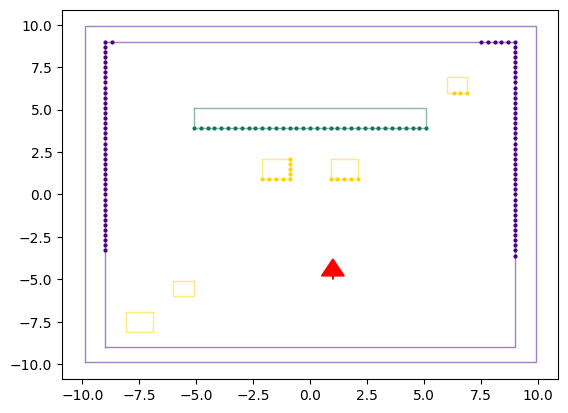

In [5]:
fov_angle = np.pi*.9
position = 1, -5
direction = np.pi/2
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

env = compiler.environment
walls_fov, objects_fov = fov_manager(position, direction)
walls_ego, objects_ego = ego_manager(position, direction)
fig, ax = plt.subplots()
fig = plot_arrow(direction, *position, ax=ax)

for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

for wall, poly in zip(walls_fov, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

for obj, poly in zip(objects_fov, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)


In [25]:
weights.operation_with(connectivity_modified, lambda a, b: a - b.get('inhibitory_phi', 0), on_missing_weights='ignore', on_missing_sources='ignore')

In [26]:
# set initial activity

activity = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('pw', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('gc', np.reshape(gc_map.fr, (*gc_map.fr.shape[:2], -1)))
)

In [27]:
dt = 0.001

In [28]:
fov_angle = np.pi*.9
position = 1, -5
direction = -np.pi/2
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

In [29]:
walls_ego, objects_ego = ego_manager(position, direction)
wall_segments = np.concatenate([points2segments(wall) for wall in walls_ego if wall.size])
ego_input_walls = tc_gen.get_grid_activity(wall_segments)

In [30]:
k_ratio = TensorGroup(
    NamedTensor('h', np.zeros((n_h_neurons, 1))),
    NamedTensor('bvc', np.zeros((n_bvc_neurons, 1))),
    NamedTensor('pr', np.zeros((n_pr_neurons, 1))),
    NamedTensor('opr', np.zeros((n_objects, 1))),
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
    NamedTensor('pw', np.expand_dims(40*ego_input_walls, 1)), # FIXME: why 40?
    NamedTensor('ovc', np.zeros((n_ovc_neurons, 1))),
    NamedTensor('opw', np.zeros((n_opw_neurons, 1))),
    NamedTensor('tr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
    NamedTensor('otr', np.zeros((n_tc_layers, n_bvc_neurons, 1))),
)

In [31]:
activity.pw += dt/connectivity.pw.to.pw['tau']*k_ratio.pw

In [32]:
def activity2rate(activity: TensorGroup, connectivity: DirectedTensorGroup) -> TensorGroup:
    """
    Converts the activity of a TensorGroup to firing rates using a sigmoid projection.

    Args:
        activity (TensorGroup): The activity of the neurons.
        connectivity (DirectedTensorGroup): The synaptic connectivity between the neurons.

    Returns:
        TensorGroup: The firing rates of the neurons.
    """
    rates = TensorGroup()
    for key, tensor in activity.data.items():
        key_ = 'pr' if 'pr' in key else key # object identity cells, use same beta and alpha as other PR neurons by definition
        rates.add_tensor(
            NamedTensor(
                key,
                1/(
                    1 + np.exp(-2*connectivity[key_, key_]['beta']*(tensor - connectivity[key_, key_]['alpha']))
                )
            )
        )
    return rates


In [33]:
rates = activity2rate(activity, connectivity)

In [59]:
len(objects_fov), [len(obj) for obj in objects_fov]

(5, [0, 0, 5, 9, 3])

In [60]:
len(objects_ego), [len(obj) for obj in objects_ego]

(5, [0, 0, 5, 9, 3])

In [40]:
objects_ego

[array([[6.1, 1. ]]),
 array([[9.1, 1.9],
        [8.8, 1.9],
        [8.5, 1.9],
        [8.2, 1.9],
        [7.9, 3.1],
        [7.9, 2.8],
        [7.9, 2.5],
        [7.9, 2.2],
        [7.9, 1.9]]),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64)]

In [34]:
n_h_neurons, n_bvc_neurons, n_pr_neurons, n_hd_neurons, n_gc_neurons, n_opw_neurons, n_ovc_neurons

(6400, 816, 2, 100, 700, 816, 816)

In [35]:
tc_gen.segment_res

0.2

In [36]:
(700 % 600)

100

In [37]:
(700 % 600) % (600 // 6)

0

Attention consists of ATTcycle steps

* (step % ATTcycle) - which step in the cycle is it?
* ATTcycle // Nobj - how many steps perform per object?
* (step % ATTcycle) % (ATTcycle // Nobj) - which step in the object cycle is it?
* (step % ATTcycle) % (ATTcycle // Nobj) vs ATTcycle // Nobj - 1 - is it the last step in the object cycle?

At each step:
1) Take all visible objects that are closer than a certain distance
2) Their oPR rate is 1
3) Compute OVC cues for selected objects if any
4) If it is the last step in the object cycle, update weights
5) OVC cues are used for k_oPW, oPR rate is used for k_oPR

In [18]:
from abc import ABC, abstractmethod


class AbstractAttention(ABC):
    @abstractmethod
    def __call__(self, objects: list[np.ndarray], return_index: bool = False) -> np.ndarray:
        pass


class RhythmicAttention(AbstractAttention):
    def __init__(self, freq: float, dt: float, n_objects: int):
        self.cycle = int(1/(freq * dt))
        self.timer = 0
        self.n_objects = n_objects
        self.attend_to = None
        self.attention_priority = np.zeros(n_objects)

    def step(self) -> bool:
        self.timer += 1
        self.timer %= self.cycle
        return self.timer == 0

    @staticmethod
    def visible_objects(objects: list[np.ndarray]) -> list[int]:
        return np.array([arr.size > 0 for arr in objects])

    def __call__(self, objects: list[np.ndarray], return_index: bool = False) -> np.ndarray:
        # True for all objects that are in the field of view in the current moment
        visible_objects = self.visible_objects(objects)
        # If there are no objects to pay attention to, pay attention to the first visible object or do not pay attention to any object
        if self.attend_to is None:
            visible_objects_indices = np.where(visible_objects)[0]

            if visible_objects_indices.size:
                self.attend_to = visible_objects_indices[0]

        # Increase the priority of the objects that are visible, zero the priority of the attended object and invisible objects
        if self.attend_to is not None:
            self.attention_priority = self.attention_priority*visible_objects + visible_objects
            self.attention_priority[self.attend_to] = 0

        if self.step(): # If the cycle is complete, attend to the other object with the highest priority or attend to no object
            self.attend_to = np.argmax(self.attention_priority) if not np.all(np.logical_not(self.attention_priority)) else None

        # Return the object that is currently being attended to
        if return_index:
            return self.attend_to
        else:
            return objects[self.attend_to] if self.attend_to is not None else np.array([])

In [109]:
np.argmax([0, 0, 0, 0])

0

In [110]:
np.where([False, True, False, False])[0][0]

1

(step % ATTcycle) % (ATTcycle // Nobj) vs ATTcycle // Nobj - 1

In [111]:
speed = 7 # m/s
dt = 0.001
# dt is 1 second / n dt in a second
# 1000 dt are in 1 second
# for 1 second I pass 7 meters
# for 1 dt I pass 7/1000 meters
# for 7 meters I need 1000/7 dt or speed / (1 / dt)

In [6]:
from typing import Mapping


class BaseCallback:
    def __init__(self):
        self._cache = None
        self._requires = list()

    @property
    def cache(self):
        return self._cache

    @property
    def requires(self):
        return self._requires

    @requires.setter
    def requires(self, requires: list):
        self._requires = requires

    def set_cache(self, cache: Mapping):
        self._cache = cache

    def on_cycle_begin(self, total_steps: int):
        pass

    def on_cycle_end(self, total_steps: int):
        pass

    def on_step_begin(self, step: int):
        pass

    def on_step_end(self, step: int):
        pass

    def on_iteration_begin(self, n_steps: int):
        pass

    def on_iteration_end(self, n_cycles_passed: int):
        pass

    def on_simulation_begin(self, n_iterations):
        pass

    def on_simulation_end(self):
        pass


class CallbacksCollection(list):
    def execute(self, method: str, *args, **kwargs):
        return tuple([getattr(callback, method)(*args, **kwargs) for callback in self])

    def validate(self):
        if len(self):
            cache = self[0].cache
            for item in self:
                for request in item.requires:
                    if request not in cache:
                        raise TypeError(
                            f"Callback {item.__class__.__name__} requires {request} to be present in the cache."
                        )

    def clean_cache(self):
        if len(self):
            all_caches = self[0].cache.keys()
            used_caches = list()

            for item in self:
                used_caches += item.requires

            unused_caches = set(all_caches) - set(used_caches)

            for cache in unused_caches:
                del self[0].cache[cache]


In [63]:
c = CallbacksCollection([BaseCallback()])

In [52]:
c[0].__class__

__main__.BaseCallback

In [7]:
from collections.abc import Mapping
from typing import Generator

class DynamicsManager:
    def __init__(self, dt: int, callbacks: list[BaseCallback] = None, cache: Mapping = None):
        self.steps_per_cycle = int(1/dt)
        self.timer = 0
        self.callbacks = CallbacksCollection() if callbacks is None else CallbacksCollection(callbacks)
        self.cache = cache if cache is not None else dict()

        for callback in self.callbacks:
            callback.set_cache(self.cache)

        self.callbacks.validate()

    def add_callback(self, callback: BaseCallback):
        callback.set_cache(self.cache)
        self.callbacks.validate()
        self.callbacks.append(callback)

    def remove_callback(self, index: int):
        callback = self.callbacks.pop(index)
        callback.set_cache(None)
        self.callbacks.clean_cache()

    def step(self):
        if not self.timer%self.steps_per_cycle: # only if new cycle is started
            self.callbacks.execute('on_cycle_begin', self.timer)

        self.callbacks.execute('on_step_begin', self.timer%self.steps_per_cycle)
        self.timer += 1
        self.callbacks.execute('on_step_end', self.timer%self.steps_per_cycle)

        if self.timer%self.steps_per_cycle == self.steps_per_cycle - 1: # only of cycle is finished
            self.callbacks.execute('on_cycle_end', self.timer)

    def run(self, n_steps: int):
        self.callbacks.execute('on_iteration_begin', n_steps)

        for _ in range(n_steps):
            self.step()

        return self.callbacks.execute('on_iteration_end', self.timer/self.steps_per_cycle)

    def __call__(self, time: float) -> Generator[Any, None, None]:

        rest = int(time*self.steps_per_cycle%self.steps_per_cycle)
        rest = [rest] if rest > 0 else []
        cycles = [self.steps_per_cycle for _ in range(int(time))] + rest

        self.callbacks.execute('on_simulation_begin', len(cycles))

        for cycle in cycles:
            yield self.run(cycle)

        self.callbacks.execute('on_simulation_end')


class CB(BaseCallback):
    def on_cycle_end(self, time: int):
        print('cycle: ', time)
        return 'stt'
    def on_step_begin(self, step: int):
        print('step: ', step)
    def on_run_begin(self, n_steps: int):
        print('n_steps: ', n_steps)
    def on_run_end(self, n_cycles_passed: int):
        print('n_cycles_passed: ', n_cycles_passed)
        return 'out'

dynamics = DynamicsManager(.1, callbacks=[
    CB()
])

for _ in dynamics(2.5):
    print('out: ', _)

for _ in dynamics(2.5):
    print('out: ', _)



step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
cycle:  9
step:  9
out:  (None,)
step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
cycle:  19
step:  9
out:  (None,)
step:  0
step:  1
step:  2
step:  3
step:  4
out:  (None,)
step:  5
step:  6
step:  7
step:  8
cycle:  29
step:  9
step:  0
step:  1
step:  2
step:  3
step:  4
out:  (None,)
step:  5
step:  6
step:  7
step:  8
cycle:  39
step:  9
step:  0
step:  1
step:  2
step:  3
step:  4
out:  (None,)
step:  5
step:  6
step:  7
step:  8
cycle:  49
step:  9
out:  (None,)


In [102]:
import math


class MovementManager:
    def __init__(self, speed: float, rotation_speed: float, position: tuple[float, float], direction: float):
        self.speed = speed
        self.rotation_speed = rotation_speed
        self.position = position
        self.direction = direction % (2 * math.pi)

    def time_per_distance(self, distance: float) -> int:
        return distance / self.speed

    def distance_per_time(self, time: float) -> float:
        return time * self.speed

    def time_per_angle(self, angle: float) -> int:
        return angle / self.rotation_speed

    def angle_per_time(self, time: float) -> float:
        return time * self.rotation_speed

    @staticmethod
    def compute_distance(position1: tuple[int, int], position2: tuple[int, int]):
        return math.sqrt(
            (position1[0] - position2[0])**2 +
            (position1[1] - position2[1])**2
        )

    @staticmethod
    def get_angle_with_x_axis(point: tuple[float, float]) -> float:
        x, y = point
        angle = math.atan2(y, x)
        if angle < 0:
            angle += 2 * math.pi
        return angle

    @staticmethod
    def smallest_angle_between(theta1: float, theta2: float) -> float:
        theta1 = theta1 % (2 * math.pi)
        theta2 = theta2 % (2 * math.pi)
        angle_diff = abs(theta1 - theta2)

        return min(angle_diff, 2 * math.pi - angle_diff)

    def __call__(self, position: tuple[int, int]) -> tuple[float, float, float]:
        d = self.compute_distance(self.position, position)
        phi = self.smallest_angle_between(self.direction, self.get_angle_with_x_axis(position))
        t = max(self.time_per_distance(d), self.time_per_angle(phi))
        return d, phi, t


In [103]:
from scipy.interpolate import interp1d

def interpolate_2d_points(points, m, method='linear'):
    # Ensure points is a numpy array
    points = np.array(points)

    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]

    # Create a parameter t along the curve (assuming points are ordered)
    t = np.linspace(0, 1, len(points))

    # Create an interpolation function for x and y separately
    fx = interp1d(t, x, kind=method)
    fy = interp1d(t, y, kind=method)

    # Create a new parameter space for the interpolated points
    t_new = np.linspace(0, 1, m)

    # Interpolate x and y
    x_new = fx(t_new)
    y_new = fy(t_new)

    # Combine x and y to get the interpolated points
    interpolated_points = np.vstack((x_new, y_new)).T

    return interpolated_points

In [278]:
import math

class TrajectoryManager:
    def __init__(self, n_points: int, method: str = 'quadratic', dx: float = None):
        self.dx = dx
        self.n_points = n_points
        self.method = method

    def __call__(
        self,
        position1: tuple[float, float],
        position2: tuple[float, float],
        angle: float
    ) -> tuple[float, float]:
        angle %= 2*math.pi

        dx = self.dx if self.dx is not None else MovementManager.compute_distance(position1, position2)/4

        angle2 = MovementManager.get_angle_with_x_axis(
            [
                position2[0] - position1[0],
                position2[1] - position1[1]
            ]
        )

        point_1 = self.create_point_on_angle(*position1, angle + .25*(angle2 - angle), dx)
        point_2 = self.create_point_on_angle(*position1, angle + .5*(angle2 - angle), 2*dx)

        coords = np.array([position1, point_1, point_2, position2])
        coords = interpolate_2d_points(coords, int(self.n_points*4/3), method=self.method)

        return coords

    @staticmethod
    def create_point_on_angle(x, y, angle, distance):
        new_x = x + distance * math.cos(angle)
        new_y = y + distance * math.sin(angle)
        return new_x, new_y



In [105]:
traj = TrajectoryManager(5, method='quadratic')
xy = traj((1, 0), (1, 1), math.pi/2)

plt.plot(xy[:, 0], xy[:, 1])

In [279]:
def arange_points(point1: tuple[float, float], point2: tuple[float, float], dist: float) -> np.ndarray:
    x1, y1 = point1
    x2, y2 = point2
    xy_ratio = math.atan2(y2 - y1, x2 - x1)
    x = np.arange(x1, x2, dist*math.cos(xy_ratio))
    y = np.arange(y1, y2, dist*math.sin(xy_ratio))
    return np.column_stack((x, y))

class PolarTrajectory:
    def __init__(
        self,
        n_angles: float,
    ):
        self.n_angles = n_angles
    def __call__(
        self,
        point1: tuple[float, float],
        direction: float,
        point2: tuple[float, float]
    ) -> np.ndarray:
        distance  = MovementManager.compute_distance(point1, point2)
        direction %= 2*math.pi
        point2_direction = MovementManager.get_angle_with_x_axis(
            [
                point2[0] - point1[0],
                point2[1] - point1[1]
            ]
        )
        if direction != point2_direction:
            angles = np.linspace(
                direction,
                point2_direction,
                self.n_angles
            )
        else:
            angles = np.array([direction])

        if angles[-1] < point2_direction:
            angles = np.append(angles, point2_direction)
        elif angles[-1] > point2_direction:
            angles[-1] = point2_direction

        steps = np.linspace(0, distance, len(angles))

        points = []
        for angle, step in zip(angles, steps):
            points.append((
                point1[0] + step*math.cos(angle),
                point1[1] + step*math.sin(angle)
            ))

        return np.array(points)

traj = PolarTrajectory(6)
point1 = 1, 0
point2 = 1, 2
xy = traj(point1,  -math.pi/2, point2)

plt.plot(point1[0], point1[1], 'ro')
plt.plot(point2[0], point2[1], 'go')
plt.plot(xy[:, 0], xy[:, 1], '.')
plt.xlim(-2, 2)
plt.ylim(-2, 2)



(-2.0, 2.0)

In [24]:
class AttentionCallback(BaseCallback):
    def __init__(self, attention: AbstractAttention):
        self._objects = list()
        self.updated = False
        super().__init__()
        self.attention = attention

    def update(self, objects: list[np.ndarray]):
        self._objects = objects
        self.updated = True

    def on_cycle_step(self, step: int):
        if self.updated:
            self.attention(self._objects)
        else:
            raise ValueError('AttentionCallback was not updated before the cycle started')

        print(self.attention.attention_priority)
    def on_cycle_end(self, total_steps: int):
        self.updated = False

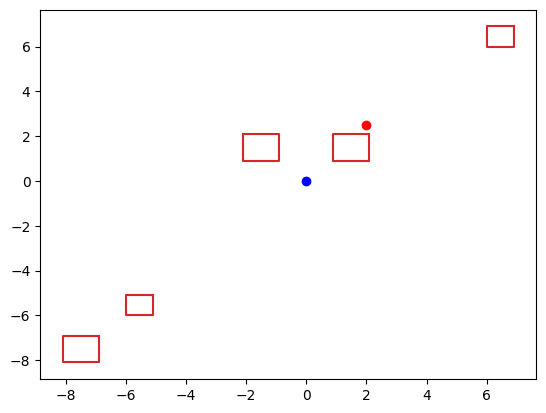

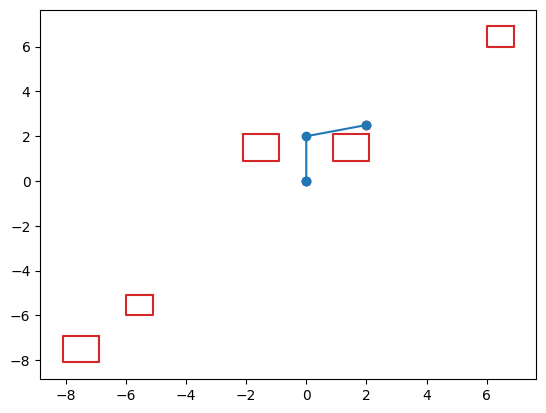

In [280]:
import numpy as np
from shapely.geometry import Point, Polygon
from queue import PriorityQueue
from shapely.affinity import scale

def resize_polygon(polygon: Polygon, increase_factor: float) -> Polygon:
    """Increase the size of a polygon by a given scale factor."""
    # Calculate the centroid of the polygon
    centroid = polygon.centroid
    # Scale the polygon around its centroid
    scaled_polygon = scale(polygon, xfact=increase_factor, yfact=increase_factor, origin=centroid)
    return scaled_polygon

def closest_grid_point(
    x: float,
    y: float,
    dx: float,
    dy: float,
    polygons: list[Polygon] = None,
    n_steps_max: int = 1000
) -> tuple:

    def is_point_outside_polygons(point: Point, polygons: list[Polygon]):
        for polygon in polygons:
            if polygon.contains(point):
                return False
        return True

    polygons = list() if polygons is None else polygons
    # Start with the closest grid point
    closest_x = round(x / dx) * dx
    closest_y = round(y / dy) * dy
    point = Point(closest_x, closest_y)

    if is_point_outside_polygons(point, polygons):
        return point.x, point.y

    # Spiral search for the closest point outside polygons
    step = 1
    while True:
        if step > n_steps_max:
            raise ValueError("Maximum number of steps reached")

        for dx_step in range(-step, step + 1):
            for dy_step in range(-step, step + 1):
                test_x = closest_x + dx * dx_step
                test_y = closest_y + dy * dy_step
                test_point = Point(test_x, test_y)
                if is_point_outside_polygons(test_point, polygons):
                    return test_x, test_y
        step += 1

def a_star_search(
    start: Point,
    goal: Point,
    polygons: list[Polygon],
    dx: float = 1,
    dy: float = 1,
    d: float = 0,
    n_steps_max: int = 1000
) -> list[Point]:
    def heuristic(a: tuple[float, float], b: tuple[float, float]) -> float:
        return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

    if d != 0:
        polygons = [resize_polygon(polygon, d) for polygon in polygons]

    actual_start = (start.x, start.y)
    actual_goal = (goal.x, goal.y)
    start = closest_grid_point(*actual_start, dx, dy, polygons)
    goal = closest_grid_point(*actual_goal, dx, dy, polygons)

    open_set = PriorityQueue()
    open_set.put((0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    step = 0
    while not open_set.empty():
        if step > n_steps_max:
            raise ValueError("Maximum number of steps reached")

        current = open_set.get()[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(Point(current[0], current[1]))
                current = came_from[current]
            path.append(Point(start[0], start[1]))
            out = path[::-1]
            out[0] = Point(actual_start)
            out[-1] = Point(actual_goal)
            return out

        # Include diagonal directions
        directions = [(dx, 0), (-dx, 0), (0, dy), (0, -dy), (dx, dy), (-dx, -dy), (dx, -dy), (-dx, dy)]
        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            neighbor_point = Point(neighbor[0], neighbor[1])

            if any(polygon.contains(neighbor_point) for polygon in polygons):
                continue

            # Distance to neighbor is sqrt(2) for diagonals, else 1
            tentative_g_score = g_score[current] + np.sqrt(direction[0]**2 + direction[1]**2)

            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                if not any(neighbor == item[1] for item in open_set.queue):
                    open_set.put((f_score[neighbor], neighbor))
        step += 1

    return None

def remove_collinear_points(points: list[Point]) -> list[Point]:
    if len(points) < 3:
        return points  # Not enough points to form a line

    # Function to calculate the cross product of vectors AB and AC
    def cross_product(A: Point, B: Point, C: Point) -> float:
        return (B.x - A.x) * (C.y - A.y) - (B.y - A.y) * (C.x - A.x)

    # Initialize the result list with the first two points
    result = [points[0], points[1]]

    for i in range(2, len(points)):
        while len(result) >= 2 and cross_product(result[-2], result[-1], points[i]) == 0:
            # If the last three points are collinear, remove the middle point
            result.pop()
        result.append(points[i])

    return result

# Example usage remains the same
# Define start and goal points

start = 0, 0
end = 2, 2.5

start = Point(*start)
goal = Point(*end)

# Define obstacles as polygons
# polygons = [Polygon([(-2, 2), (2, 5), (5, 5), (5, 2)]),
#             Polygon([(7, 7), (7, 9), (9, 9), (9, 7)])]
polygons = [obj.polygon.obj for obj in compiler.environment.objects]
# polygons = []

fig, ax = plt.subplots()
ax.plot(start.xy[0], start.xy[1], 'ob')
ax.plot(goal.xy[0], goal.xy[1], 'or')



for poly in polygons:
    plot_polygon(poly, ax=ax)

plt.show()

path = a_star_search(start, goal, polygons, 1, 1, 0)


%matplotlib inline
fig, ax = plt.subplots()
ax.plot(start.xy[0], start.xy[1], 'ob')
ax.plot(goal.xy[0], goal.xy[1], 'or')



for poly in polygons:
    plot_polygon(poly, ax=ax)

if path:
    path = remove_collinear_points(path)
    plt.plot([point.xy[0] for point in path], [point.xy[1] for point in path], 'o-')

plt.show()

In [257]:
polygons

[<POLYGON ((-5.1 -5.1, -6 -5.1, -6 -6, -5.1 -6, -5.1 -5.1))>,
 <POLYGON ((-6.9 -6.9, -8.1 -6.9, -8.1 -8.1, -6.9 -8.1, -6.9 -6.9))>,
 <POLYGON ((2.1 2.1, 0.9 2.1, 0.9 0.9, 2.1 0.9, 2.1 2.1))>,
 <POLYGON ((-2.1 2.1, -0.9 2.1, -0.9 0.9, -2.1 0.9, -2.1 2.1))>,
 <POLYGON ((6.9 6.9, 6 6.9, 6 6, 6.9 6, 6.9 6.9))>]

In [281]:
class AStarTrajectory(TrajectoryManager):
    def __init__(self, environment: Environment, n_points: int, method: str = 'quadratic', dx: float = 1, poly_increase_factor: float = 0):
        super().__init__(n_points, method, dx)
        self.environment = environment
        self.poly_increase_factor = poly_increase_factor

    def __call__(
        self,
        position1: tuple[float, float],
        position2: tuple[float, float],
        angle: float
    ) -> tuple[float, float]:
        angle %= 2*math.pi
        angle2 = MovementManager.get_angle_with_x_axis(
            [
                position2[0] - position1[0],
                position2[1] - position1[1]
            ]
        )

        average_angle = (angle + angle2) / 2


        # Check if angles are across the 0 radians point
        if abs(angle - angle2) > math.pi:
            average_angle += math.pi  # Adjust the average if angles straddle the 0 radians line

        # Normalize the result to be between 0 and 2pi
        average_angle = average_angle % (2 * math.pi)
        point_1 = self.create_point_on_angle(*position1, angle + .25*(angle2 - angle), self.dx/2)
        point_2 = self.create_point_on_angle(*position1, angle + .5*(angle2 - angle), self.dx)

        additional_points = remove_collinear_points(a_star_search(
            Point(position1),
            Point(position2),
            [obj.polygon.obj for obj in self.environment.objects] +
            [obj.polygon.obj for obj in self.environment.walls],
            self.dx, self.dx, self.poly_increase_factor
        ))
        if additional_points is None:
            additional_points = [position1, position2]
        else:
            additional_points = [(point.x, point.y) for point in additional_points]

        all_points = [position1, point_1, point_2, *additional_points[1:-1], position2]

        coords = np.array(all_points)
        coords = interpolate_2d_points(coords, int(self.n_points*4/3) + len(additional_points) - 2, method=self.method)

        return coords

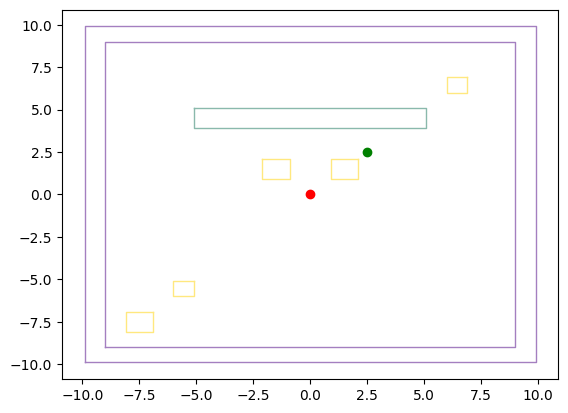

In [268]:
start = 0, 0
end = 2.5, 2.5
angle = math.pi/2

fig, ax = plt.subplots()
for wall in compiler.environment.walls:
    plot_polygon(wall.polygon, ax=ax, alpha=0.5, linewidth=1)
for obj in compiler.environment.objects:
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

ax.plot(start[0], start[1], 'ro')
ax.plot(end[0], end[1], 'go')

(0.0, 0.0) (1, 3)
ok


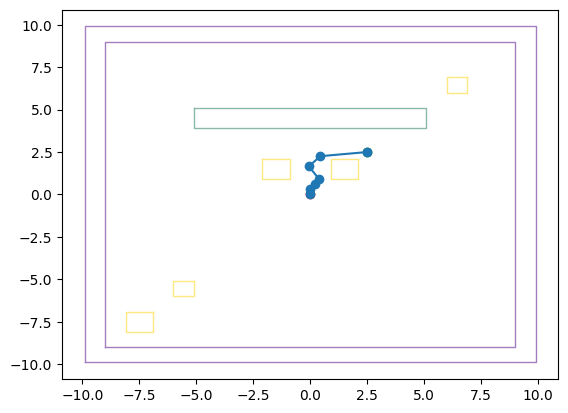

In [270]:
start = 0, 0
end = 2.5, 2.5
angle = math.pi/2

fig, ax = plt.subplots()
for wall in compiler.environment.walls:
    plot_polygon(wall.polygon, ax=ax, alpha=0.5, linewidth=1)
for obj in compiler.environment.objects:
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

ax.plot(start[0], start[1], 'ro')
ax.plot(end[0], end[1], 'go')

traj = AStarTrajectory(
    compiler.environment,
    n_points=5,
    method='quadratic',
    dx=1,
    poly_increase_factor=0
)


path = traj(start, end, angle)

ax.plot(path[:, 0], path[:, 1], 'o-')


In [176]:
for x, y in zip(*polygons[0].exterior.xy):
    print(x)

(-2.0, 2.0)
(2.0, 5.0)
(5.0, 5.0)
(5.0, 2.0)
(-2.0, 2.0)


In [332]:

from typing import Mapping

class MovementCallback(BaseCallback):
    def __init__(self, dt: float, movement_manager: MovementManager):
        super().__init__()
        self.dt = dt
        self.movement = movement_manager
        self.dist = self.movement.distance_per_time(self.dt)
        self.ang = self.movement.angle_per_time(self.dt)

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.cache['position'] = self.movement.position
        self.cache['direction'] = self.movement.direction
        self.cache['move_target'] = None
        self.cache['rotate_target'] = None
        self.requires = ['position', 'direction', 'move_target', 'rotate_target']

    def rotate_to_target(self, position: tuple[float, float], direction: float, target: tuple[float, float]) -> float:
        angle_to_target = math.atan2(
            target[1] - position[1],
            target[0] - position[0]
        )
        angle_to_target = (angle_to_target + 2 * math.pi) % (2 * math.pi)
        angle_diff = angle_to_target - direction
        angle_diff = (angle_diff + math.pi) % (2 * math.pi) - math.pi
        rotation = min(abs(angle_diff), self.ang) * math.copysign(1, angle_diff)
        return (direction + rotation) % (2 * math.pi)

    def move_to_target(self) -> tuple[float, float]:
        # return position[0] + self.dist * math.cos(direction),\
        #     position[1] + self.dist * math.sin(direction)
        ang = self.movement.get_angle_with_x_axis(
            [
                self.cache['move_target'][0] - self.cache['position'][0],
                self.cache['move_target'][1] - self.cache['position'][1]
            ]
        )
        return self.cache['position'][0] + self.dist * math.cos(ang),\
            self.cache['position'][1] + self.dist * math.sin(ang)

    def on_step_begin(self, step: int): # changes position and angle of an agent
        if self.cache['position'] is not None and\
            self.cache['move_target'] is not None:
            dist = self.movement.compute_distance(self.cache['position'], self.cache['move_target'])
            if dist <= self.dist:
                self.cache['move_target'] = None

        if self.cache['direction'] is not None and\
            self.cache['rotate_target'] is not None:
                ang = self.movement.smallest_angle_between(
                    self.cache['direction'],
                    self.movement.get_angle_with_x_axis(
                        [
                            self.cache['rotate_target'][0] - self.cache['position'][0],
                            self.cache['rotate_target'][1] - self.cache['position'][1]
                        ]
                    )
                )
                print(ang, self.ang)
                if ang <= self.ang:
                    self.cache['rotate_target'] = None

        if self.cache['move_target'] is not None:
            self.cache['position'] = self.move_to_target()
            self.cache['direction'] = self.rotate_to_target(self.cache['position'], self.cache['direction'], self.cache['move_target'])
        elif self.cache['rotate_target'] is not None:
            self.cache['direction'] = self.rotate_to_target(self.cache['position'], self.cache['direction'], self.cache['rotate_target'])


class FOVCallback(BaseCallback):
    def __init__(self, fov_manager: FOVManager):
        super().__init__()
        self.fov = fov_manager

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.cache['walls_fov'] = None
        self.cache['objects_fov'] = None
        self.requires = ['position', 'direction']

    def on_step_begin(self, step: int):
        self.cache['walls_fov'], self.cache['objects_fov'] = self.fov(self.cache['position'], self.cache['direction'])

class EgoCallback(BaseCallback):
    def __init__(self, ego_manager: EgoManager):
        super().__init__()
        self.ego = ego_manager

    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.cache['walls_ego'] = None
        self.cache['objects_ego'] = None
        self.requires = ['walls_ego', 'objects_ego', 'position', 'direction']

    def on_step_begin(self, step: int):
        if self.cache['position'] is not None and self.cache['direction'] is not None:
            self.cache['walls_ego'], self.cache['objects_ego'] = self.ego(self.cache['position'], self.cache['direction'])


class EgoSegmentationCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.cache['walls_ego_segments'] = list()
        self.cache['objects_ego_segments'] = list()
        self.requires = ['walls_ego', 'objects_ego', 'walls_ego_segments', 'objects_ego_segments']

    def on_step_begin(self, step: int):
        if self.cache['walls_ego'] is not None:
            self.cache['walls_ego_segments'] = list()

            for points_ego in self.cache['walls_ego']:
                if not points_ego.size:
                    self.cache['walls_ego_segments'].append(points_ego)
                else:
                    self.cache['walls_ego_segments'].append(points2segments(points_ego))

        if self.cache['objects_ego'] is not None:
            self.cache['objects_ego_segments'] = list()
            for points_ego in self.cache['objects_ego']:
                if not points_ego.size:
                    self.cache['objects_ego_segments'].append(points_ego)
                else:
                    self.cache['objects_ego_segments'].append(points2segments(points_ego))


class ParietalWindowCallback(BaseCallback):
    def set_cache(self, cache: Mapping):
        super().set_cache(cache)
        self.cache['walls_pw'] = None
        self.cache['objects_pw'] = None
        self.requires = ['walls_ego_segments', 'objects_ego_segments', 'walls_pw', 'objects_pw', 'tc_gen']

    def on_step_begin(self, step: int):
        if len(self.cache['walls_ego_segments']) and any([segments.size for segments in self.cache['walls_ego_segments']]):
            self.cache['walls_pw'] = self.cache['tc_gen'].get_grid_activity(
                np.concatenate(
                    [segments for segments in self.cache['walls_ego_segments'] if segments.size]
                )
            )
        else:
            self.cache['walls_pw'] = np.zeros_like(self.cache['walls_pw'])

        if len(self.cache['objects_ego_segments']) and any([segments.size for segments in self.cache['objects_ego_segments']]):
            self.cache['objects_pw'] = self.cache['tc_gen'].get_grid_activity(
                np.concatenate(
                    [segments for segments in self.cache['objects_ego_segments'] if segments.size]
                )
            )
        else:
            self.cache['objects_pw'] = np.zeros_like(self.cache['objects_pw'])



In [ ]:
%matplotlib qt
import time
from matplotlib.backend_bases import KeyEvent
from matplotlib.gridspec import GridSpec
from matplotlib.backend_bases import MouseButton
from copy import deepcopy

class PlottingCallback(BaseCallback):
    def __init__(
        self,
        x_bvc: np.ndarray,
        y_bvc: np.ndarray,
        update_rate: int = 100
    ):
        super().__init__()
        self.x_bvc = x_bvc
        self.y_bvc = y_bvc
        self.update_rate = update_rate
        # Create a figure and a plot
        self.fig = plt.figure(figsize=(10, 5))
        # Create a GridSpec layout
        self.gs = GridSpec(12, 12, figure=self.fig)

        # Add the first subplot on the left side (spanning two rows)
        self.ax1 = self.fig.add_subplot(self.gs[:, :5])

        # Add the second subplot on the top right
        self.ax2 = self.fig.add_subplot(self.gs[:6, 6:])

        # Add the third subplot on the bottom right with 3D projection
        self.ax3 = self.fig.add_subplot(self.gs[6:, 6:9], projection='3d')

        # self.ax4 = self.fig.add_subplot(self.gs[7:10, 8:10])
        self.ax4 = self.fig.add_subplot(self.gs[6:, 9:12], projection='3d')

        # self.ax5 = self.fig.add_subplot(self.gs[10:, 8:10])

        # plt.subplots_adjust(bottom=0.2)

        # Set the limits of the plot
        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax2.set_xlim(-20, 20)
        self.ax2.set_ylim(-20, 20)
        self.ax3.set_axis_off()

        self.ax3.view_init(azim=-90, elev=90)
        self.ax3.set_axis_off()
        self.ax4.view_init(azim=-90, elev=90)
        self.ax4.set_axis_off()

        # # Connect the key press event to the handler
        # self.fig.canvas.mpl_connect('key_press_event', self.on_key)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def set_cache(self, cache: Any):
        super().set_cache(cache)
        self.cache['move_target'] = None
        self.cache['rotate_target'] = None
        self.cache['fig'] = self.fig
        self.cache['alo_axis'] = self.ax1
        self.cache['ego_axis'] = self.ax2
        self.requires = [
            'env',
            'tc_gen',
            'move_target',
            'rotate_target',
            'walls_fov',
            'objects_fov',
            'walls_ego',
            'objects_ego',
            'walls_ego_segments',
            'objects_ego_segments',
            'walls_pw',
            'objects_pw',
            'position',
            'direction',
            'fig',
            'alo_axis',
            'ego_axis'
        ]

    def on_click(self, event: KeyEvent):
        self.plot()

        if event.inaxes is self.ax1:

            if event.button is MouseButton.LEFT:
                self.ax1.plot(event.xdata, event.ydata, 'rx')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.cache['move_target'] = event.xdata, event.ydata
                self.cache['rotate_target'] = None
            elif event.button is MouseButton.RIGHT:
                self.ax1.plot(event.xdata, event.ydata, 'co')
                self.fig.canvas.draw()
                plt.pause(.00001)
                self.cache['rotate_target'] = event.xdata, event.ydata
                self.cache['move_target'] = None

    def on_step_end(self, step: int):

        if not step % self.update_rate:

            self.plot()

    def on_simulation_end(self, n_cycles_passed: int):
        plt.close()

    def plot(self):
        self.clean_axes()
        self.plot_environment()
        if self.cache['move_target'] is not None:
            self.ax1.plot(*self.cache['move_target'], 'rx')
        if self.cache['rotate_target'] is not None:
            self.ax1.plot(*self.cache['rotate_target'], 'co')
        self.plot_fov()
        self.plot_ego()
        self.plot_agent()
        self.plot_pw()
        self.fig.canvas.draw()
        plt.pause(.00001)

    def clean_axes(self):
        self.ax1.clear(), self.ax2.clear(), self.ax3.clear(), self.ax4.clear()#, self.ax5.clear()
        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax2.set_xlim(-15, 15)
        self.ax2.set_ylim(-15, 15)

        self.ax3.view_init(azim=-90, elev=90)
        self.ax3.set_axis_off()
        self.ax4.view_init(azim=-90, elev=90)
        self.ax4.set_axis_off()

    def plot_environment(self):
        for obj in self.cache['env'].objects + self.cache['env'].walls:
            plot_polygon(obj.polygon, ax=self.ax1, alpha=0.5, linewidth=1)

    def plot_fov(self):
        if self.cache['walls_fov']:
            for wall, poly in zip(self.cache['walls_fov'], self.cache['env'].walls):
                self.ax1.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
        if self.cache['objects_fov']:
            for obj, poly in zip(self.cache['objects_fov'], self.cache['env'].objects):
                self.ax1.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

    def plot_ego(self):
        _ = plot_arrow(np.pi/2, 0, -.75, ax=self.ax2)

        if self.cache['walls_ego_segments']:
            # for wall, poly in zip(self.cache['walls_ego'], self.cache['env'].walls):
            #     self.ax2.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
            for segments, poly in zip(self.cache['walls_ego_segments'], self.cache['env'].walls):
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ax2.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1)

        if self.cache['objects_ego_segments']:
            # for obj, poly in zip(self.cache['objects_ego'], self.cache['env'].objects):
            #     self.ax2.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)
            for segments, poly in zip(self.cache['objects_ego_segments'], self.cache['env'].objects):
                for seg in segments:
                    x_start, y_start, x_end, y_end = seg
                    self.ax2.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1)

    def plot_agent(self):
        if self.cache['position'] is not None and self.cache['direction'] is not None:
            self.ax1.plot(*self.cache['position'], 'bo')
            self.ax1.arrow(*self.cache['position'], 0.5 * math.cos(self.cache['direction']), 0.5 * math.sin(self.cache['direction']))

    def plot_pw(self):
        if self.cache['walls_pw'] is not None:
            self.ax3.plot_surface(
                self.x_bvc,
                self.y_bvc,
                np.reshape(self.cache['walls_pw'], (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
                cmap='coolwarm'
            )

        if self.cache['objects_pw'] is not None:
            self.ax4.plot_surface(
                self.x_bvc,
                self.y_bvc,
                np.reshape(self.cache['objects_pw'], (self.cache['tc_gen'].n_bvc_theta, self.cache['tc_gen'].n_bvc_r)),
                cmap='coolwarm'
            )

class MovementSchedulerCallback(BaseCallback):
    def __init__(self, positions: list[tuple[float, float]] = None):
        super().__init__()
        self.positions = positions if positions is not None else list()

    def set_cache(self, cache: Any):
        super().set_cache(cache)
        self.cache['movement_schedule'] = self.positions
        self.requires = [
            'position',
            'move_target',
            'movement_schedule'
        ]

    def on_step_end(self, step: int):
        if len(self.cache['movement_schedule']):
            if self.cache['move_target'] is None:
                self.cache['move_target'] = self.cache['movement_schedule'].pop(0)


class TrajectoryCallback(BaseCallback):
    def __init__(self, trajectory_manager: TrajectoryManager):
        super().__init__()
        self.trajectory = trajectory_manager

    def set_cache(self, cache: Any):
        super().set_cache(cache)
        if 'movement_schedule' not in self.cache:
            self.cache['movement_schedule'] = list()
        self.cache['trajectory'] = list()
        self.requires = [
            'position',
            'move_target',
            'direction',
            'movement_schedule',
            'trajectory'
        ]

    def on_step_begin(self, step: int):
        if self.cache['move_target'] is not None:
            if self.cache['move_target'] not in self.cache['trajectory']:
                xy = self.trajectory(self.cache['position'], self.cache['move_target'], self.cache['direction'])
                self.cache['trajectory'] = [tuple(item) for item in xy.tolist()]
                self.cache['movement_schedule'] = deepcopy(self.cache['trajectory'])
                self.cache['move_target'] = self.cache['movement_schedule'].pop(0)

class TrajectoryPlotterCallback(BaseCallback):
    def __init__(self, update_rate: int = 100):
        super().__init__()
        self.update_rate = update_rate

    def set_cache(self, cache: Any):
        super().set_cache(cache)
        self.requires = [
            'movement_schedule',
            'move_target',
            'position',
            'fig',
            'alo_axis'
        ]

    def on_step_end(self, step: int):

        if not step % self.update_rate:

            self.plot()

    def plot(self):

        if self.cache['position'] is not None and \
            not (
                self.cache['move_target'] is not None
                and self.cache['move_target'] not in self.cache['trajectory']
            ):
            first_points = [self.cache['position'], self.cache['move_target']]\
                if self.cache['move_target'] not in self.cache['movement_schedule']\
                and self.cache['move_target'] is not None\
                else [self.cache['position']]
            all_points = first_points + self.cache['movement_schedule']
            if len(self.cache['movement_schedule']):
                self.cache['alo_axis'].plot(
                    self.cache['movement_schedule'][-1][0],
                    self.cache['movement_schedule'][-1][1],
                    'ro'
                )
            for from_, to in zip(all_points[:-1], all_points[1:]):
                self.cache['alo_axis'].plot(*zip(from_, to), 'g-')

            self.cache['fig'].canvas.draw()
            plt.pause(.00001)


%matplotlib qt
fov_angle = np.pi
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)

cache = {'env': compiler.environment, 'tc_gen': tc_gen}
res = 0.01
dynamics = DynamicsManager(
    res,
    callbacks=[
        MovementCallback(
            res,
            MovementManager(10, math.pi*4, (0, 0), 0)
        ),
        FOVCallback(fov_manager),
        EgoCallback(ego_manager),
        EgoSegmentationCallback(),
        ParietalWindowCallback(),
        PlottingCallback(x_bvc, y_bvc, 10),
        TrajectoryPlotterCallback(10),
        MovementSchedulerCallback(
            # [
            #     (5, 0),
            #     (5, 2.5),
            #     (-5, 2.5),
            #     (-5, -5),
            #     (5, -5),
            #     (5, -2.5)
            # ]
        ),
        # TrajectoryCallback(TrajectoryManager(20, dx=1)),
        TrajectoryCallback(
            AStarTrajectory(
                compiler.environment,
                n_points=20,
                method='quadratic',
                dx=1,
                poly_increase_factor=1.5
            )
        )
    ],
    cache=cache
)

for _ in dynamics(100):
    print('out: ', _)



In [329]:
dynamics.cache['objects_pw']

array([4.17829468e-79, 2.57776586e-78, 3.65913487e-77, 1.09024793e-75,
       6.03269315e-74, 5.31948807e-72, 6.22075052e-70, 7.78721043e-68,
       8.16867497e-66, 5.45171371e-64, 1.70463303e-62, 1.78354571e-61,
       4.32596973e-61, 1.63454719e-61, 6.27216450e-63, 1.54606950e-65,
       2.09383280e-73, 1.29171375e-72, 1.83350334e-71, 5.46284294e-70,
       3.02279665e-68, 2.66554403e-66, 3.11739842e-64, 3.90287427e-62,
       4.09480975e-60, 2.73356685e-58, 8.55044395e-57, 8.95086786e-56,
       2.17255579e-55, 8.21684717e-56, 3.15720641e-57, 7.79675783e-60,
       5.44995455e-68, 3.36118717e-67, 4.76958436e-66, 1.42080434e-64,
       7.86138717e-63, 6.93250174e-61, 8.10836653e-59, 1.01527855e-56,
       1.06542657e-54, 7.11455815e-53, 2.22631918e-51, 2.33192033e-50,
       5.66450874e-50, 2.14469527e-50, 8.25290129e-52, 2.04223105e-54,
       7.39851548e-63, 4.55466000e-62, 6.45098631e-61, 1.91921837e-59,
       1.06137340e-57, 9.35904701e-56, 1.09474274e-53, 1.37097805e-51,
      

In [90]:
np.isclose([1, 1], [1, 1]).all()

True

In [79]:
dynamics.cache['direction']

0.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

t = np.linspace(0, 2*np.pi, 100)
y = np.sin(t)

line, = ax.plot(t, y)
dots, = ax.plot([], [], 'ro')  # Initialize empty red dots

def onclick(event):
    if event.button == 1:  # Check if left mouse button is clicked
        x_click = event.xdata
        y_click = event.ydata
        ax.plot(x_click, y_click, 'ro')  # Plot red dot at clicked position
        fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

for i in range(200):
    line.set_ydata(np.sin(t + i/100))
    fig.canvas.draw()
    plt.pause(0.001)

plt.show()

In [31]:
fig, ax = plt.subplots()

t = np.linspace(0, 2*np.pi, 100)
y = np.sin(t)

for i in range(200):
    ax.clear()
    y = np.sin(t + i/100)
    ax.plot(t, y)
    fig.canvas.draw()
    plt.pause(0.001)


KeyboardInterrupt: 

In [249]:
for i in range(100):
    if not i%10:
        print(i)

0
10
20
30
40
50
60
70
80
90


In [ ]:


class AgentPlotter:


    def init_bvc(self):
        self.bvc_act = np.zeros((tc_gen.n_bvc, 1))
        self.k_bvc = self.bvc_act
        self.weights.bvc.to.bvc - self.connectivity.bvc.to.bvc['inhibitory_phi']
        self.bvc_rate = 1/(
            1 + np.exp(
                -2*connectivity.bvc.to.bvc['beta'] * (self.bvc_act - connectivity.bvc.to.bvc['alpha'])
            )
        )
        grid_side = int(np.sqrt(weights.gc.to.pc.shape[0]))
        self.bvc_plane = np.zeros((grid_side, grid_side, self.tc_gen.n_bvc))

    def __init__(
        self,
        env: Environment,
        fov: FOVManager,
        ego: EgoManager,
        tc_gen: TCGenerator,
        weights: DirectedTensorGroup,
        connectivity: DirectedTensorGroup,
        activity: TensorGroup,
        attention: AbstractAttention,
        dynamics: DynamicsManager
    ):
        self.env = env
        self.fov = fov
        self.ego = ego
        self.tc_gen = tc_gen
        self.weights = weights
        self.connectivity = connectivity
        self.activity = activity
        self.dynamics = dynamics
        self.attention = AttentionCallback(attention)
        self.dynamics.add_callback(self.attention)

        # Initial coordinates and angle
        self.x, self.y, self.angle = 0, 0, 0

        # Step size for moving and rotating
        self.move_step = 0.5
        self.angle_step = np.pi / 20  # radians

        # Create a figure and a plot
        self.fig = plt.figure(figsize=(10, 5))
        # Create a GridSpec layout
        self.gs = GridSpec(12, 12, figure=self.fig)

        # Add the first subplot on the left side (spanning two rows)
        self.ax1 = self.fig.add_subplot(self.gs[:, :5])

        # Add the second subplot on the top right
        self.ax2 = self.fig.add_subplot(self.gs[:6, 6:])

        # Add the third subplot on the bottom right with 3D projection
        self.ax3 = self.fig.add_subplot(self.gs[6:, 5:8], projection='3d')

        self.ax4 = self.fig.add_subplot(self.gs[7:10, 8:10])
        self.ax5 = self.fig.add_subplot(self.gs[10:, 8:10])

        # plt.subplots_adjust(bottom=0.2)

        # Set the limits of the plot
        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax2.set_xlim(-20, 20)
        self.ax2.set_ylim(-20, 20)
        self.ax3.set_axis_off()

        # Connect the key press event to the handler
        self.fig.canvas.mpl_connect('key_press_event', self.on_key)
        self.init_bvc()

    def update_agent(self, dx: float = 0, dy: float = 0, dangle: float = 0):
        dx, dy = self.ego.rotate([(dx, dy)], -self.angle)[0]
        dist = np.sqrt(dx**2 + dy**2)

        self.x += dx
        self.y += dy
        self.angle += dangle

        walls_fov, objects_fov = self.fov((self.x, self.y), self.angle)

        self.ax1.clear(), self.ax2.clear(), self.ax3.clear()
        self.ax4.clear()
        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax2.set_xlim(-15, 15)
        self.ax2.set_ylim(-15, 15)
        _ = plot_arrow(self.angle, *(self.x, self.y), ax=self.ax1)

        hd = self.tc_gen.get_hd_activity(np.array([self.angle]))
        self.ax4.plot(hd, 'o')

        for obj in self.env.objects + self.env.walls:
            plot_polygon(obj.polygon, ax=self.ax1, alpha=0.5, linewidth=1)

        for wall, poly in zip(walls_fov, self.env.walls):
            self.ax1.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

        for obj, poly in zip(objects_fov, self.env.objects):
            self.ax1.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

        walls_ego, objects_ego = self.ego((self.x, self.y), self.angle)

        self.attention.update(objects_ego)
        self.dynamics(dist, dangle)

        _ = plot_arrow(np.pi/2, 0, -.75, ax=self.ax2)

        all_segments = list()
        for wall_fov, poly in zip(walls_ego, compiler.environment.walls):
            if not wall_fov.size:
                continue

            # wall_segments = points2segments(ego_manager.rotate(wall_fov, -self.angle))
            wall_segments = points2segments(wall_fov)
            all_segments.append(wall_segments)
            for seg in wall_segments:
                x_start, y_start, x_end, y_end = seg
                self.ax2.plot([x_start, x_end], [y_start, y_end], color=poly.polygon.texture.color, linewidth=1)

        all_segments = np.concatenate(all_segments)

        bvc_act = self.tc_gen.get_grid_activity(all_segments)

        self.ax3.plot_surface(x_bvc, y_bvc, np.reshape(bvc_act, (self.tc_gen.n_bvc_theta, self.tc_gen.n_bvc_r)), cmap='coolwarm')
        self.ax3.view_init(azim=-90, elev=90)
        self.ax3.set_axis_off()

        for obj, poly in zip(objects_ego, self.env.objects):
            self.ax2.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)


        self.fig.canvas.draw()

    def on_key(self, event: KeyEvent):
        if event.key == 'w':
            self.update_agent(dx=self.move_step)
        elif event.key == 'a':
            self.update_agent(dy=self.move_step)
        elif event.key == 's':
            self.update_agent(dx=-self.move_step)
        elif event.key == 'd':
            self.update_agent(dy=-self.move_step)
        elif event.key == 'q':
            self.update_agent(dangle=self.angle_step)
        elif event.key == 'e':
            self.update_agent(dangle=-self.angle_step)

    def run(self):
        self.update_agent()
        plt.show()

%matplotlib qt
fov_angle = (np.pi/6)*.9
position = 1, -5
direction = -np.pi/2
fov_manager = FOVManager(compiler.environment, fov_angle)
ego_manager = EgoManager(fov_manager)
attention = RhythmicAttention(7, dt, n_objects)
dynamics = DynamicsManager(dt, 10, 10)

simulator = AgentPlotter(
    compiler.environment,
    fov_manager,
    ego_manager,
    tc_gen,
    weights,
    connectivity,
    activity,
    attention,
    dynamics
)
simulator.run()

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0

In [ ]:
attention.cycle

142

In [ ]:
dynamics = DynamicsManager(dt, 10, 10)
dynamics.steps_per_meter

100.0

In [ ]:
simulator.dynamics.steps_per_circle

100.0

In [ ]:
dynamics.callbacks

In [ ]:
n_objects

5

In [ ]:
tc_gen.polar_distance.shape

(51, 16)

In [ ]:
plt.rcParams['keymap.quit'].remove('q')
plt.rcParams['keymap.save'].remove('s')